In [1]:
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import gensim

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('../dmdlassignment2/AnnoMI/dataset.csv')
df.head()

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form t...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You dri...",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks whe...,therapist_input,NaN


# Data Cleaning and Preprocessing

In [3]:
import string
import re

stop_words = set(stopwords.words('english'))

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    split=re.split("\W+",text.lower()) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stop_words]
    return text

def lemmatize(text):
    lemmatized_words = []
    for word in text:
        lemmatized_words.append(lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_words)
    

In [4]:
transformed_df = pd.DataFrame(columns=['utterance_text', 'interlocutor'])

for index, text in enumerate(df['utterance_text']):
    # Apply an aggregation function
    transformed = lemmatize(remove_stopwords(tokenize(remove_punctuation(text))))
    new_data = pd.Series({'utterance_text': transformed, 'interlocutor': df['interlocutor'][index]})
    transformed_df.loc[index] = new_data

transformed_df.head()

,utterance_text,interlocutor
0,thank fill give form everyone year regardless ...,therapist
1,sure,client
2,let see look put drink alcohol least four time...,therapist
3,mmhmm,client
4,usually three four drink drink,therapist


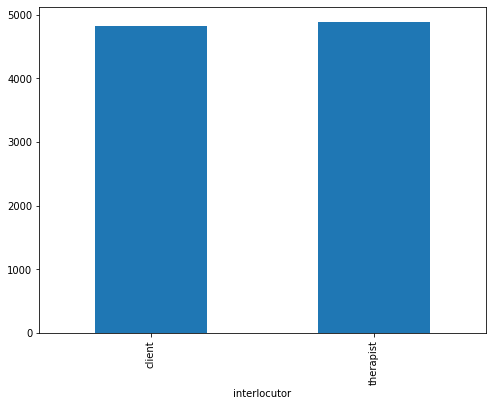

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
transformed_df.groupby('interlocutor').utterance_text.count().plot.bar(ylim=0)
plt.show()

## Extract Labels

In [5]:
transformed_df['interlocutor_id'] = transformed_df['interlocutor'].factorize()[0]
interlocutor_id_df = transformed_df[['interlocutor', 'interlocutor_id']].drop_duplicates().sort_values('interlocutor_id')
interlocutor_to_id = dict(interlocutor_id_df.values)
id_to_interlocutor = dict(interlocutor_id_df[['interlocutor_id', 'interlocutor']].values)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(transformed_df.utterance_text).toarray()
labels = transformed_df.interlocutor_id
print(features.shape)

(9699, 2483)


## Extract the features and labels from the dataset

Finding the terms that are the most correlated with each of the interlocutor:

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

N = 5
processed_data = {}
for interlocutor_type, interlocutor_id in sorted(interlocutor_to_id.items()):
  print('Processing interlocutor type {}'.format(interlocutor_type))
  processed_data[interlocutor_type] = {}
  features_chi2 = chi2(features, labels == interlocutor_id)
  if interlocutor_id == 1:
    indices = np.argsort(features_chi2[0])
  else:
    indices = np.argsort(features_chi2[-1])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  processed_data[interlocutor_type]['unigrams'] = [v for v in feature_names if len(v.split(' ')) == 1]
  processed_data[interlocutor_type]['bigrams'] = [v for v in feature_names if len(v.split(' ')) == 2]
  print("------------------------------------------------------------------")
  print("# '{}':".format(interlocutor_type))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(processed_data[interlocutor_type]['unigrams'][-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(processed_data[interlocutor_type]['bigrams'][-N:])))

Processing interlocutor type client
------------------------------------------------------------------
# 'client':
  . Most correlated unigrams:
. youve
. dont
. youre
. okay
. yeah
  . Most correlated bigrams:
. youd like
. im wonder
. dont really
. sound like
. dont know
Processing interlocutor type therapist
------------------------------------------------------------------
# 'therapist':
  . Most correlated unigrams:
. calm
. ones
. cop
. diabetes
. resume
  . Most correlated bigrams:
. feel way
. outside smoke
. months ago
. um ill
. think feel


## Proportion of bigrams for each interlocutor

In [11]:
import plotly.express as px

count_occurances = []
utterance = ' '.join(transformed_df['utterance_text'].apply(''.join))
def create_feature_map(key):
    for bigram in processed_data[key]['bigrams']:
        count = utterance.count(bigram)
        count_occurances.append(count)
    processed_data[key]['bigram_count'] = pd.DataFrame(list(zip(processed_data[key]['bigrams'], count_occurances)),
                columns =['ngram', 'count'])
    
    fig = px.bar(processed_data[key]['bigram_count'][:20], x='ngram', y='count', title=f"Counts of top bigrams for {key}", template='plotly_white', labels={'ngram': 'Bigram', 'count': 'Count'})
    fig.show()

In [12]:
create_feature_map('therapist')
create_feature_map('client')

## Qualitative comparisons
Word embeddings (dense embeddings to be precise) enable qualitative comparisons of words. They can represent words, and, by extension, concepts or documents as high dimensional vectors, which also provide opportunities for interesting visualizations. Below is a simple representation of bigrams using a bubble chart:

In [13]:
from sklearn.manifold import TSNE
def create_bg_similarity(key):
    features_bigrams = tfidf.fit_transform(processed_data[key]['bigrams']).toarray()
    X_embedded = TSNE(n_components=2).fit_transform(features_bigrams)
    
    data = {
    'tsne_1': X_embedded[:, 0][:30],
    'tsne_2': X_embedded[:, 1][:30],
    'count': processed_data[key]['bigram_count']['count'][:30],
    'bigram': processed_data[key]['bigrams'][:30]
    }
    # print(len(X_embedded[:, 0]), len(X_embedded[:, 1]), len(processed_data['therapist']['bigrams']))
    
    fig = px.scatter(data, x='tsne_1', y='tsne_2', hover_name='bigram', text='bigram', color='count', size='count', size_max=45
                     , template='plotly_white', title=f"Bigram similarity and frequency for {key}", labels={'words': 'Avg. Length<BR>(words)'}
                     , color_continuous_scale=px.colors.sequential.Sunsetdark)
    fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

In [14]:
create_bg_similarity('therapist')

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [15]:
create_bg_similarity('client')

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Hyperparameter Tuning of the classifiers for the eventual Ensemble Classifier

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

def construct_model(dataframe):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        KNeighborsClassifier(), 
        RandomForestClassifier(random_state=0)
    ]
    logregress_parameters = {
        'penalty' : ['l2'],     
        'C'       : np.logspace(-3,3,7),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter': [1000]
    }
    knn_parameters = {
        'n_neighbors': np.arange(1, 25, 2)
    }
    randomforest_parameters = {
        'n_estimators': [50, 100, 200, 300]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        knn_parameters, 
        randomforest_parameters
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(X_train, y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [43]:
construct_model(transformed_df)

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

# Accuracy for predicting client behaviour

In [44]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.7469996444233733
__________________________________________________________
KNeighborsClassifier
Tuned Hyperparameters : {'n_neighbors': 3}
Accuracy : 0.5972587412587413
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 100}
Accuracy : 0.7471520682707123
__________________________________________________________


## Ensemble Classifier

In [45]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(processed_data['estimators'], 
                            voting='hard', 
                            weights=[1,1,1], n_jobs=-1)  # n-estimators

X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, indices_test = train_test_split(features, labels, transformed_df.index, test_size=0.33, random_state=0, shuffle=True)

ensemble.fit(X_train, y_train)

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

VotingClassifier(estimators=[('LogisticRegression',
                              GridSearchCV(cv=10, error_score='raise',
                                           estimator=LogisticRegression(random_state=0),
                                           n_jobs=-1,
                                           param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                       'max_iter': [1000],
                                                       'penalty': ['l2'],
                                                       'solver': ['newton-cg',
                                                                  'lbfgs',
                                                                  'liblinear']},
                                           scoring='accuracy')),
                             ('KNeighborsClassifier',
                              GridSea...',
                                           estimator=KNeighbors

## Accuracy with the Ensemble Classifier increased by around 1%

In [46]:

accuracy = ensemble.score(processed_data['X_test'], processed_data['y_test'])
print("Ensemble classifier Accuracy:", accuracy)

Ensemble classifier Accuracy: 0.7541393314589191


## Heatmap for accuracy with tuned hyperparameters for Ensemble model which gave the best accuracy

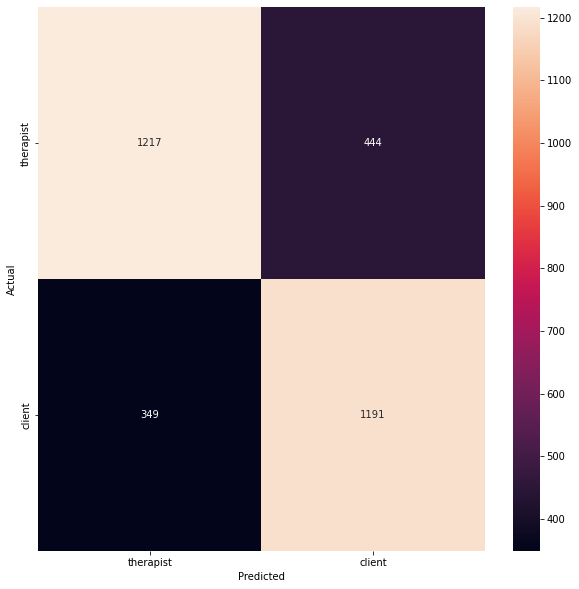

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

processed_data['y_pred'] = ensemble.predict(processed_data['X_test'])
processed_data['conf_mat'] = confusion_matrix(processed_data['y_test'], processed_data['y_pred'])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(processed_data['conf_mat'], annot=True, fmt='d',
            xticklabels=interlocutor_id_df.interlocutor.values, yticklabels=interlocutor_id_df.interlocutor.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## List wrong predictions

In [32]:
from IPython.display import display

for predicted in interlocutor_id_df.interlocutor_id:
    for actual in interlocutor_id_df.interlocutor_id:
      if predicted != actual and processed_data['conf_mat'][actual, predicted] >= 10:
        print("'{}' predicted as '{}' : {} examples.".format(id_to_interlocutor[actual], id_to_interlocutor[predicted], processed_data['conf_mat'][actual, predicted]))
        display(transformed_df.loc[processed_data['indices_test'][(processed_data['y_test'] == actual) & (processed_data['y_pred'] == predicted)]][['interlocutor', 'utterance_text']])
        print('')

'client' predicted as 'therapist' : 349 examples.


,interlocutor,utterance_text
2563,client,feel great actually
1813,client,youd real fool
6528,client,seem like every time uh drink couple drink ten...
9,client,okay
3725,client,hi
...,...,...
7531,client,go away make things difficult
2655,client,specifically father want support time feel lik...
3789,client,plus theres people do countless time go read
7052,client,like truck drive stuff like



'therapist' predicted as 'client' : 444 examples.


,interlocutor,utterance_text
8394,therapist,yeah
8201,therapist,yeah sort like shortterm transition something ...
7003,therapist,believe
7982,therapist,mmhmm whwhat dont like
6391,therapist,yeah
...,...,...
6591,therapist,would work
5951,therapist,okay phone distraction keep phone away
8183,therapist,take care part reliable childcare would defini...
4301,therapist,sure chuckle secure profession


## Model Evaluation

In [33]:
from sklearn import metrics

print(metrics.classification_report(processed_data['y_test'], processed_data['y_pred'], target_names=transformed_df['interlocutor'].unique()))
    

              precision    recall  f1-score   support

   therapist       0.78      0.73      0.75      1661
      client       0.73      0.77      0.75      1540

    accuracy                           0.75      3201
   macro avg       0.75      0.75      0.75      3201
weighted avg       0.75      0.75      0.75      3201

